In [1]:
import numpy as np
import torch as th
from alphagen.utils.correlation import batch_pearsonr
from alphagen_ocean.calculator_ import QLibStockDataCalculator
from alphagen_ocean.stock_data_ import StockData
from glob import glob
from utils import *
import ray
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ray.init(num_cpus=160, ignore_reinit_error=True)
start_time = 20210101
end_time = 20210630


@ray.remote
def remote_backtest_json(path, start_time, end_time):
    return backtest_json(path, start_date=start_time, end_date=end_time)


@ray.remote
def remote_batch_pearsonr(tensor1, tensor2):
    return th.nanmean(batch_pearsonr(tensor1, tensor2)).item()


def get_backtest_result(start_time, end_time, save_dir="./checkpoints/*sat*/"):
    paths = sorted(glob(save_dir))
    json_paths = [
        sorted(
            glob(path + "*.json"), key=lambda x: int(x.split("/")[-1].split("_")[0])
        )[-1]
        for path in paths
    ]
    futures = [
        remote_backtest_json.remote(path, start_time, end_time) for path in json_paths
    ]

    s = time.time()
    factors = ray.get(futures)
    e = time.time()
    print(f"calc y cost:{int(e-s)}s")
    futures = []
    n = len(factors)
    df_corr = np.zeros((n, n))

    s = time.time()
    for i in range(n):
        for j in range(i + 1, n):
            future = remote_batch_pearsonr.remote(factors[i], factors[j])
            futures.append((i, j, future))

    for i, j, future in futures:
        result = ray.get(future)
        df_corr[i][j] = result
        df_corr[j][i] = result
    e = time.time()
    print(f"calc corr cost:{int(e-s)}s")

    data_test = StockData(start_time, end_time)
    calter = QLibStockDataCalculator(data_test)
    y1 = calter.ret1d
    y2 = calter.ret2d
    y5 = calter.ret5d
    futures = []
    for y in factors:
        futures.append(remote_batch_pearsonr.remote(y, y1))
        futures.append(remote_batch_pearsonr.remote(y, y2))
        futures.append(remote_batch_pearsonr.remote(y, y5))
    s = time.time()
    results = ray.get(futures)
    e = time.time()
    print(f"calc IC cost:{int(e-s)}s")
    data = {"y1": results[::3], "y2": results[1::3], "y5": results[2::3]}
    df_ic = pd.DataFrame(data)
    index_name = pd.Index([path.split("/")[-2] for path in json_paths])
    df_ic.index = index_name
    return factors, df_corr, df_ic

2023-08-15 17:22:21,887	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


In [3]:
ray.shutdown()

In [4]:
factors_21, df_corr_21, df_ic_21 = get_backtest_result(20210101, 20210601)
factors_19, df_corr_19, df_ic_19 = get_backtest_result(20190103, 20201231)

2023-08-15 17:22:33,084	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(remote_backtest_json pid=32388) fetching trading calendar...
(remote_backtest_json pid=32388) fetching done
(remote_backtest_json pid=32286) fetching trading calendar... [repeated 41x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(remote_backtest_json pid=32399) fetching done [repeated 40x across cluster]
calc y cost:58s
calc corr cost:122s
fetching trading calendar...
fetching done
calc IC cost:1s
(remote_backtest_json pid=32362) fetching trading calendar... [repeated 3x across cluster]
(remote_backtest_json pid=32362) fetching done [repeated 3x across cluster]
calc y cost:299s
calc corr cost:1321s
fetching trading calendar...
fetching done
calc IC cost:6s


In [5]:
# plt.figure(figsize=(20,20))
# sns.heatmap(pd.DataFrame(df_corr),annot=True,fmt=".2f")

In [40]:
def remove_low_ic_factors(df_ic_insample, df_ic_outsample, strict=True):
    if strict:
        print("2019-2020")
        df_ic_insample = df_ic_insample.reset_index(drop=True)
        df_ic_outsample = df_ic_outsample.reset_index(drop=True)
        decay = df_ic_insample - df_ic_outsample
        idx = (decay / df_ic_insample < 0.5).all(axis=1) & (df_ic_insample > 0).all(
            axis=1
        )
        print(df_ic_insample[idx])
        print("2021")
        print(df_ic_outsample[idx])
    return df_ic_outsample[idx].index.tolist()

In [41]:
pool = remove_low_ic_factors(df_ic_19, df_ic_21)

2019-2020
          y1        y2        y5
0   0.021091  0.023302  0.027854
4   0.015210  0.017875  0.023540
5   0.040616  0.044743  0.056126
6   0.019831  0.023290  0.032273
7   0.020718  0.022899  0.027423
8   0.030616  0.032383  0.038084
14  0.014005  0.016085  0.020034
15  0.014103  0.016235  0.020176
18  0.021057  0.023275  0.027694
23  0.020847  0.023036  0.027476
26  0.021059  0.023279  0.027688
27  0.015762  0.017997  0.022511
29  0.019502  0.021614  0.025294
30  0.021102  0.023327  0.027741
33  0.021057  0.023273  0.027681
40  0.019919  0.018260  0.013218
2021
          y1        y2        y5
0   0.013608  0.015959  0.014924
4   0.010803  0.013237  0.012728
5   0.034280  0.034808  0.036641
6   0.018118  0.020288  0.021294
7   0.013556  0.015908  0.014890
8   0.021670  0.021706  0.020488
14  0.010031  0.011719  0.010834
15  0.010180  0.011840  0.010953
18  0.013639  0.015995  0.014964
23  0.013550  0.015888  0.014868
26  0.013636  0.015996  0.014964
27  0.011449  0.013254  0.01

In [42]:
pool

[0, 4, 5, 6, 7, 8, 14, 15, 18, 23, 26, 27, 29, 30, 33, 40]

In [8]:
pool

['20230811171316_satd_lexpr8_lopt34_10_793',
 '20230811171750_satd_lexpr8_lopt34_10_863',
 '20230811171800_satd_lexpr8_lopt34_10_42',
 '20230813143935_satd_lexpr8_lopt34_10_322',
 '20230813143936_satd_lexpr8_lopt34_10_65',
 '20230813143936_satd_lexpr8_lopt34_10_714',
 '20230813145501_satd_lexpr8_lopt34_10_726',
 '20230814092613_satd_lexpr8_lopt34_10_788',
 '20230814092615_satd_lexpr8_lopt34_10_18',
 '20230814102408_satd_lexpr15_lopt34_10_319',
 '20230815092933_satd_lexpr10_lopt34_10_571',
 '20230815095228_satd_lexpr10_lopt34_10_762',
 '20230815095245_satd_lexpr10_lopt34_10_843',
 '20230815095542_satd_lexpr10_lopt34_10_251',
 '20230815095842_satd_lexpr10_lopt34_10_414',
 '20230815145015_satd_lexpr10_lopt34_10_4119']

In [11]:
save_dir = "./checkpoints/*satd*/"
paths = sorted(glob(save_dir))
json_paths = [
    sorted(glob(path + "*.json"), key=lambda x: int(x.split("/")[-1].split("_")[0]))[-1]
    for path in paths
]
json_paths = [i.split("/")[-2] for i in json_paths]

In [15]:
json_paths

['20230811171316_satd_lexpr8_lopt34_10_793',
 '20230811171327_satd_lexpr8_lopt34_10_622',
 '20230811171332_satd_lexpr8_lopt34_10_360',
 '20230811171749_satd_lexpr8_lopt34_10_598',
 '20230811171750_satd_lexpr8_lopt34_10_863',
 '20230811171800_satd_lexpr8_lopt34_10_42',
 '20230813143935_satd_lexpr8_lopt34_10_322',
 '20230813143936_satd_lexpr8_lopt34_10_65',
 '20230813143936_satd_lexpr8_lopt34_10_714',
 '20230813145451_satd_lexpr8_lopt34_10_856',
 '20230813145452_satd_lexpr8_lopt34_10_769',
 '20230813145457_satd_lexpr8_lopt34_10_197',
 '20230813145458_satd_lexpr8_lopt34_10_226',
 '20230813145458_satd_lexpr8_lopt34_10_262',
 '20230813145501_satd_lexpr8_lopt34_10_726',
 '20230814092613_satd_lexpr8_lopt34_10_788',
 '20230814092614_satd_lexpr8_lopt34_10_177',
 '20230814092615_satd_lexpr8_lopt34_10_143',
 '20230814092615_satd_lexpr8_lopt34_10_18',
 '20230814092617_satd_lexpr8_lopt34_10_506',
 '20230814092618_satd_lexpr8_lopt34_10_233',
 '20230814095854_satd_lexpr8_lopt34_10_967',
 '20230814095

In [18]:
factor_idx = []
for fact in pool:
    factor_idx.append(np.where(np.array(json_paths) == fact)[0][0])
factor_idx

In [24]:
y_f = [factors_21[i] for i in factor_idx]

In [25]:
n = len(y_f)
futures = []
df_corr = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        future = remote_batch_pearsonr.remote(y_f[i], y_f[j])
        futures.append((i, j, future))

for i, j, future in futures:
    result = ray.get(future)
    df_corr[i][j] = result
    df_corr[j][i] = result

<Axes: >

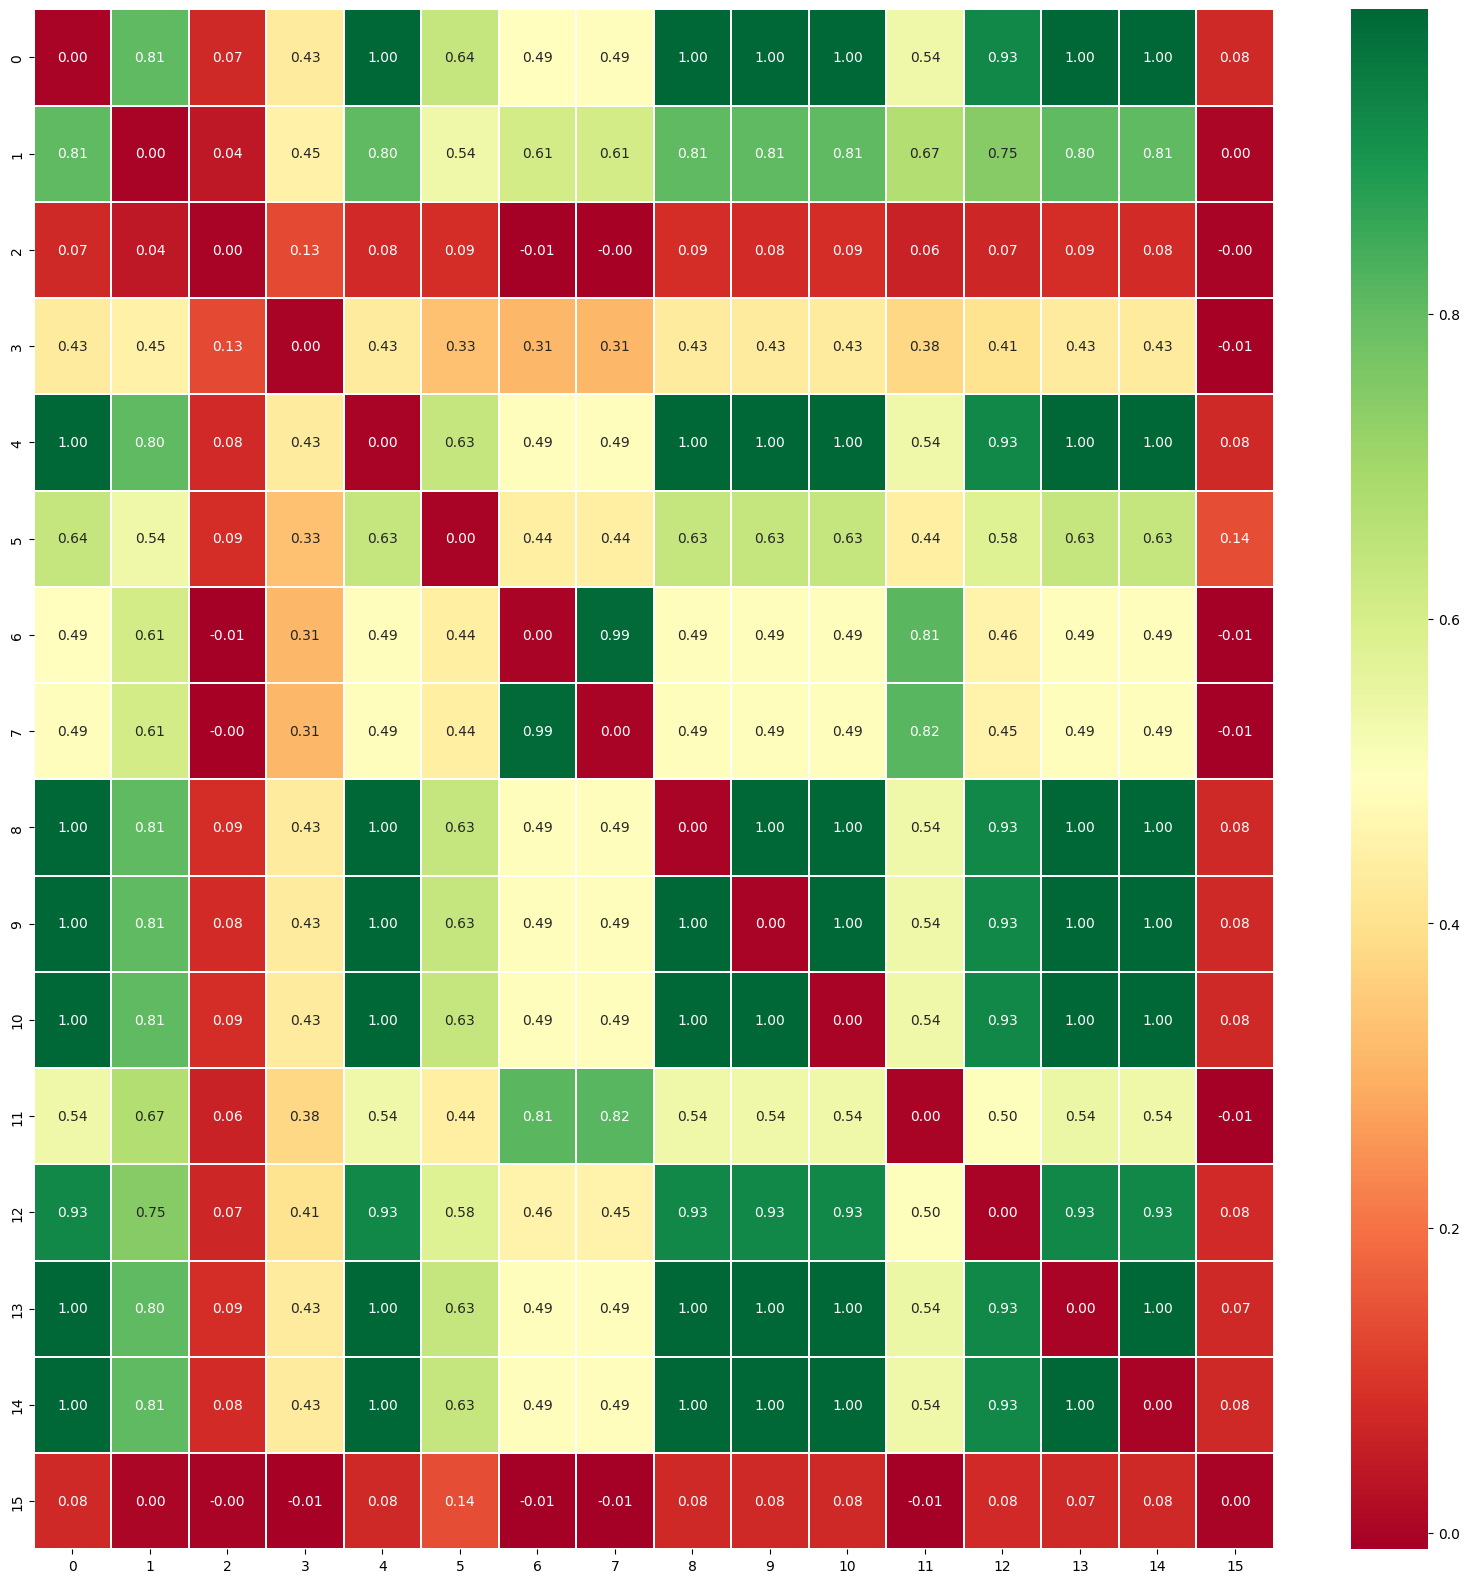

In [28]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="RdYlGn", linewidths=0.2)

In [33]:
def remove_high_corr_factors(df_corr, threshold=0.8):
    factors = list(range(df_corr.shape[0]))

    # 获取相关性大于阈值的因子对
    high_corr_pairs = np.where(np.triu(df_corr, 1) > threshold)
    high_corr_pairs = [(i, j) for i, j in zip(*high_corr_pairs)]

    removed_factors = set()

    while high_corr_pairs:
        # 对于每一对高相关性的因子，计算它们与其他因子的平均相关性
        avg_corrs = {}
        for factor1, factor2 in high_corr_pairs:
            avg_corr_factor1 = np.mean(
                [df_corr[factor1, k] for k in factors if k not in [factor1, factor2]]
            )
            avg_corr_factor2 = np.mean(
                [df_corr[factor2, k] for k in factors if k not in [factor1, factor2]]
            )
            avg_corrs[(factor1, factor2)] = (avg_corr_factor1, avg_corr_factor2)

        # 从每一对高相关性的因子中，移除平均相关性较高的那个因子
        for (factor1, factor2), (
            avg_corr_factor1,
            avg_corr_factor2,
        ) in avg_corrs.items():
            if avg_corr_factor1 > avg_corr_factor2:
                removed_factors.add(factor1)
            else:
                removed_factors.add(factor2)

        # 更新factors列表
        factors = [f for f in factors if f not in removed_factors]

        # 重新获取相关性大于阈值的因子对
        high_corr_pairs = np.where(np.triu(df_corr[factors][:, factors], 1) > threshold)
        high_corr_pairs = [(factors[i], factors[j]) for i, j in zip(*high_corr_pairs)]

    return factors


print(remove_high_corr_factors(df_corr))

[1, 2, 3, 5, 6, 12, 15]


In [ ]:
# timer wrapper
def timer(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{func.__name__} took {end-start} seconds")
        return result

    return wrapper


class Backtester(object):
    def __init__(
        self,
        start_time: int = 20190101,
        end_time: int = 20201231,
        pattern: str = "./checkpoints/*sat*/",
    ) -> None:
        self.start_time = start_time
        self.end_time = end_time
        self.paths = sorted(glob(pattern))
        self.json_paths = [
            sorted(
                glob(path + "*.json"), key=lambda x: int(x.split("/")[-1].split("_")[0])
            )[-1]
            for path in self.paths
        ]

    @timer
    def calc_factor(self):
        futures = [
            remote_backtest_json.remote(path, self.start_time, self.end_time)
            for path in self.json_paths
        ]
        factors = ray.get(futures)
        self.factors = factors

    def calc_corr(self):
        for i in range(n):
            for j in range(i + 1, n):
                future = remote_batch_pearsonr.remote(self.factors[i], self.factors[j])
                futures.append((i, j, future))

        for i, j, future in futures:
            result = ray.get(future)
            df_corr[i][j] = result
            df_corr[j][i] = result
        self.df_corr = df_corr

    def calc_ic(self):
        data_test = StockData(self.start_time, self.end_time)
        calter = QLibStockDataCalculator(data_test)
        y1 = calter.ret1d
        y2 = calter.ret2d
        y5 = calter.ret5d
        futures = []
        for y in self.factors:
            futures.append(remote_batch_pearsonr.remote(y, y1))
            futures.append(remote_batch_pearsonr.remote(y, y2))
            futures.append(remote_batch_pearsonr.remote(y, y5))
        s = time.time()
        results = ray.get(futures)
        e = time.time()
        print(f"calc IC cost:{int(e-s)}s")
        data = {"y1": results[::3], "y2": results[1::3], "y5": results[2::3]}
        df_ic = pd.DataFrame(data)
        index_name = pd.Index([path.split("/")[-2] for path in json_paths])
        df_ic.index = index_name
        self.df_ic = df_ic

    def make(self):
        self.calc_factor()
        self.calc_corr()
        self.calc_ic()
        return self.factors, self.df_corr, self.df_ic


def remove_low_ic_factors(df_ic_insample, df_ic_outsample, strict=True):
    if strict:
        print("2019-2020")
        df_ic_insample = df_ic_insample.reset_index(drop=True)
        df_ic_outsample = df_ic_outsample.reset_index(drop=True)
        decay = df_ic_insample - df_ic_outsample
        idx = (decay / df_ic_insample < 0.5).all(axis=1) & (df_ic_insample > 0).all(
            axis=1
        )
        print(df_ic_insample[idx])
        print("2021")
        print(df_ic_outsample[idx])
    return df_ic_outsample[idx].index.tolist()


def remove_high_corr_factors(df_corr, threshold=0.8):
    factors = list(range(df_corr.shape[0]))

    # 获取相关性大于阈值的因子对
    high_corr_pairs = np.where(np.triu(df_corr, 1) > threshold)
    high_corr_pairs = [(i, j) for i, j in zip(*high_corr_pairs)]

    removed_factors = set()

    while high_corr_pairs:
        # 对于每一对高相关性的因子，计算它们与其他因子的平均相关性
        avg_corrs = {}
        for factor1, factor2 in high_corr_pairs:
            avg_corr_factor1 = np.mean(
                [df_corr[factor1, k] for k in factors if k not in [factor1, factor2]]
            )
            avg_corr_factor2 = np.mean(
                [df_corr[factor2, k] for k in factors if k not in [factor1, factor2]]
            )
            avg_corrs[(factor1, factor2)] = (avg_corr_factor1, avg_corr_factor2)

        # 从每一对高相关性的因子中，移除平均相关性较高的那个因子
        for (factor1, factor2), (
            avg_corr_factor1,
            avg_corr_factor2,
        ) in avg_corrs.items():
            if avg_corr_factor1 > avg_corr_factor2:
                removed_factors.add(factor1)
            else:
                removed_factors.add(factor2)

        # 更新factors列表
        factors = [f for f in factors if f not in removed_factors]

        # 重新获取相关性大于阈值的因子对
        high_corr_pairs = np.where(np.triu(df_corr[factors][:, factors], 1) > threshold)
        high_corr_pairs = [(factors[i], factors[j]) for i, j in zip(*high_corr_pairs)]

    return factors


class DoubleChecker(object):
    def __init__(self, raw: Backtester, new: Backtester, strict=True):
        self.raw = raw
        self.new = new
        self.strict = strict
        self.factors_idx = list(range(len(new.factors)))

    def filter_ic(
        self,
    ):
        return remove_low_ic_factors(self.raw.df_ic, self.new.df_ic, self.strict)

    def filter_corr(
        self,
    ):
        raw_factors = remove_high_corr_factors(self.raw.df_corr)
        new_factors = remove_high_corr_factors(self.new.df_corr)
        return list(set(raw_factors) & set(new_factors))

    def make(self):
        ic_idx = self.filter_corr()
        corr_idx = self.filter_ic()
        result_idx = list(set(ic_idx) & set(corr_idx))


s